In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

# 1. Fair coin from biased coin

$P(h) = p, \ P(t) = q = 1 - p$

$P(ht) = P(th) = pq \ \rightarrow$ use for fair generation $\rightarrow \ P(\text{same}) = 2pq, \ P(\text{dif}) = 1 - 2pq$

$P(hh) = p^2, \ P(tt) = q^2$

**Idea:** Flip twice -> if different outcomes, report the first one, otherwise repeat.

$
\begin{align}
\mathbb{E}[\text{flips}] = e &= \texttt{succeed_first_try} \ \lor \ \texttt{repeat} \\
e &= 2 \cdot P(\text{same}) + P(\text{dif}) \cdot (2 + e) \\
e &= 2 \cdot 2pq + (1-2pq) \cdot (2 + e) \\
e (1 - 1 + 2pq) &= 4pq + 2 - 4pq \\
e \cdot 2pq &= 2 \\
e &= \frac{1}{pq} = \frac{1}{p \cdot (1-p)}
\end{align}
$

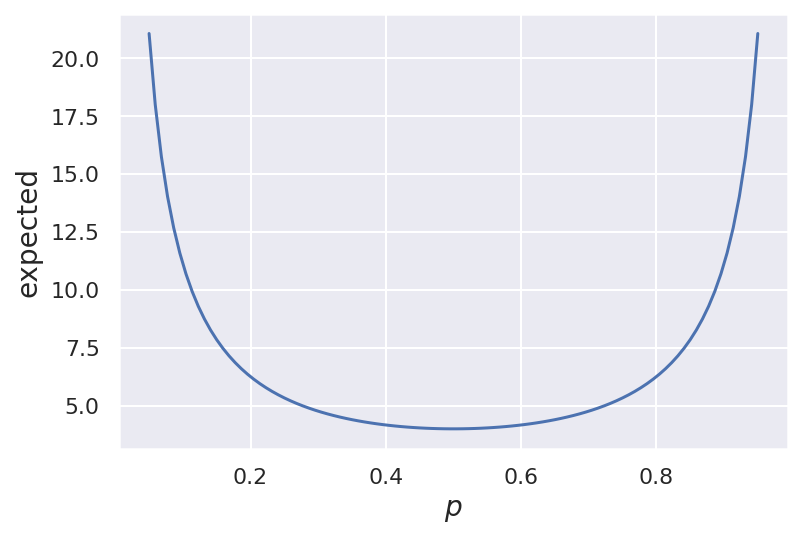

In [2]:
x = 0.05
ps = np.linspace(x, 1-x, 100)
es = 1 / (ps * (1 - ps))
plt.plot(ps, es)
plt.xlabel('$p$', fontsize=14)
plt.ylabel('expected', fontsize=14)
pass

# 2. `rand10` from `rand7` (1)

**Idea:** call `rand7` twice -> if $x \leq 40$, ok, otherwise repeat

$
\begin{align}
\mathbb{E}[\text{calls}] = e &= \texttt{succeed_first_try} \ \lor \ \texttt{repeat} \\
e &= 2 \cdot P(x \leq 40) + P(x > 40) \cdot (2 + e)\\
e &= 2 \cdot \frac{40}{49} + 2\cdot\frac{9}{49} + e \cdot \frac{9}{49} \\
e \cdot \frac{40}{49} &= 2 \\
e &= \frac{49}{20} = 2.45
\end{align}
$

### Ref
- https://leetcode.com/problems/implement-rand10-using-rand7/

In [3]:
rand7 = lambda: np.random.randint(low=1, high=8)

def rand10():
    # idea: use [1,40], discard and repeat for [41,49]
    
    n = ((rand7() - 1) * 7) + rand7()
    
    if n <= 40:
        return 1 + n % 10
    else:
        return rand10()

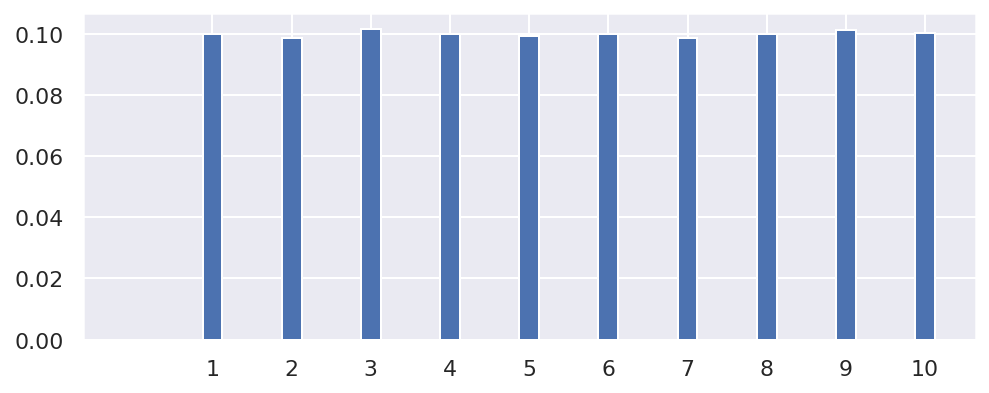

In [4]:
xs = np.array([rand10() for _ in range(100000)])
support = np.unique(xs)
plt.figure(figsize=(8,3))
bins = np.arange(support.max() + 2) - 0.5
plt.hist(xs, bins=bins, rwidth=0.25, color='b', density=True)
plt.xticks(support)
pass

# 3. Random points in a circle

In [5]:
PI = np.arccos(-1)
rand = lambda: np.random.uniform()

def show(gen_func, circle, N=10_000):
    xs, ys = zip(*[gen_func(circle) for _ in range(N)])
    plt.figure(figsize=(5,5))
    plt.scatter(xs, ys, s=0.2)
    plt.grid(False)
    pass

### 3.1. Using polar coordinates

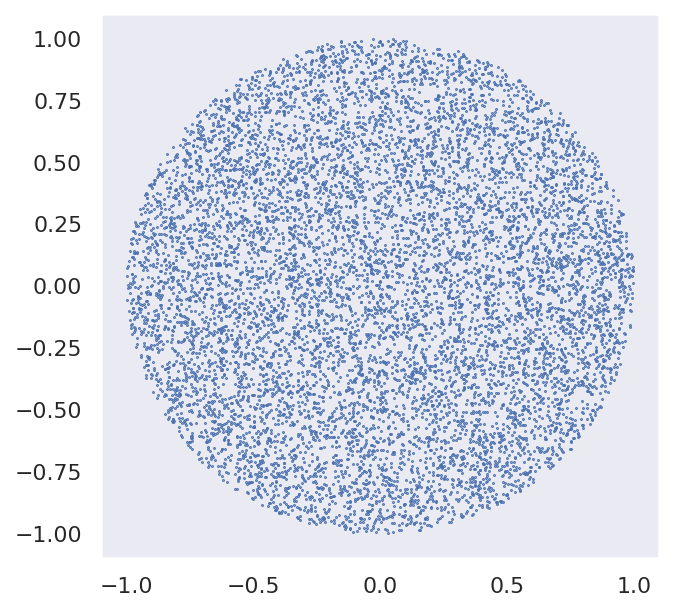

In [6]:
def polar_coordinates(circle):
    """
    see: https://stackoverflow.com/questions/5837572/generate-a-random-point-within-a-circle-uniformly
    """
    cx, cy, r = circle
    
    l = np.sqrt(rand()) * r
    a = 2 * PI * rand()
    
    x = cx + l * np.cos(a)
    y = cy + l * np.sin(a)
    
    return x, y

show(polar_coordinates, circle=(0,0,1), N=10_000)

## 3.2. Using rejection sampling

- Given a circle $\mathcal{C}$ centered in $(c_x, c_y)$ of radius $r$, we can enclose it in a square $\mathcal{S}$ of size $2r$
- One possible method for generating random points in $\mathcal{C}$ is to generate random points in the square and discard those outside the circle
- For each step we need to generate 2 points $(x, y)$
- Thus, the expected number of trials can be found using $e = 2 \cdot p + (1-p) \cdot (2 + e)$, where $p = P((x,y) \in \mathcal{C}) = \mathcal{A}_{\mathcal{C}} \ / \ \mathcal{A}_{\mathcal{S}} = \pi \ / \ 4$
- We find that $e = 8 \ / \ \pi$

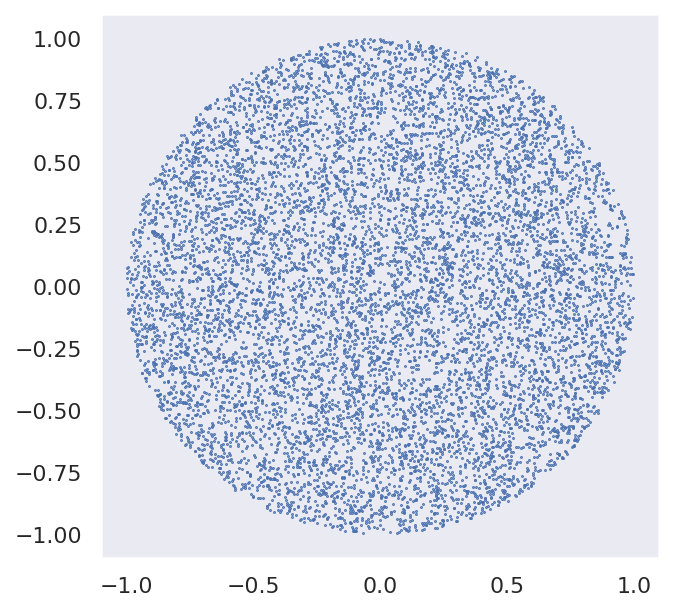

In [7]:
def rejection_sampling(circle):
    cx, cy, r = circle
    
    xm, xM = cx-r, cx+r
    ym, yM = cy-r, cy+r
    
    rx = xm + rand() * (xM - xm)
    ry = ym + rand() * (yM - ym)
    
    dist = (cx - rx) ** 2 + (cy - ry) ** 2
    if dist <= r ** 2:
        return rx, ry
    
    return rejection_sampling(circle) # discard + repeat

show(rejection_sampling, circle=(0,0,1), N=10_000)

# What we notice

$
\begin{align}
e &= \texttt{success}_1 \ \lor \ \texttt{repeat} \\
e &= \texttt{success}_1 \ \lor \ (\texttt{fail}_1 \ \land \ (\texttt{success}_2 \ \lor \ \texttt{repeat})) \\
e &= \texttt{success}_1 \ \lor \ (\texttt{fail}_1 \ \land \ (\texttt{fail}_2 \ \land \ (\texttt{success}_3 \ \lor \ \texttt{repeat}))) \\
e &= \texttt{success}_1 \ \lor \ (\texttt{fail}_1 \ \land \ (\texttt{fail}_2 \ \land \ (\texttt{fail}_3 \ \lor \ (\texttt{success}_4 \ \lor \ \texttt{repeat}))))
\end{align}
$

$\vdots$

Therefore, if we let $n =$ number of samples in one step (e.g. calls to `rand7`, coin tosses), and $p = P(\texttt{success})$, then:

$
\begin{align}
e &= p \cdot n + (1-p) \cdot (n + e) \\
e &= p \cdot n + n + e - p \cdot n - p \cdot e \\
e \cdot p &= n \Rightarrow e = n \ / \ p
\end{align}
$

Thus, $\color{blue}{\mathbb{E}[\texttt{trials}] = n \ / \ P(\texttt{success})}$

This essentially forms a Markov Chain, so we are interested in expected number of transitions until we reach a certain state. See [this answer](https://math.stackexchange.com/a/947339).